## 「ベイズ推論による機械学習入門」P.128 ポアソン混合モデルにおけるギブスサンプリング

### ポアソン混合モデル

* クラスタkの観測モデルをポアソン分布とする（式1）。
* ポアソン分布のパラメータ $\lambda$ の事前分布をガンマ分布（共役事前分布）とする（式2）。
* 各クラスタの混合比率 $\pi$ はカテゴリ分布のため、事前分布をK次元のディリクレ分布（共役事前分布）とする（式3）。
* K個の観測モデルを各データ点に割り当てる潜在変数Sをカテゴリ分布とする（式4）。
* K個のポアソン分布に対して混合比率 $\pi$ を使って加重平均を取って各データ点に対する確率を求める（式5）。

$$\mathcal{p}(\mathcal{x}_n|\lambda_k) = Poi(\mathcal{x}_n|\lambda_k)\quad (1)$$

$$\mathcal{p}(\lambda_k) = Gam(\lambda_k|a, b)\quad (2)$$

$$\mathcal{p}(\boldsymbol\pi) = Dir(\boldsymbol\pi|\boldsymbol\alpha)\quad (3)$$

$$\mathcal{p}(s_n|\pi) = Cat(s_n|\pi)\quad (4)$$

$$\sum_{k=1}^K \pi_k Poi(x_n|\lambda_k)\quad (5)$$


### 観測モデルの設定

In [1]:
using Distributions
using Plots

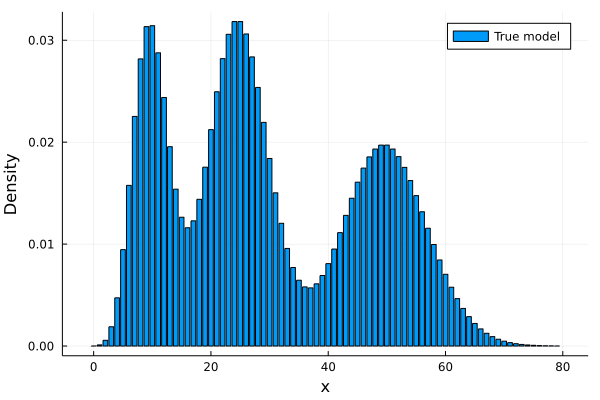

In [14]:
# ポアソン分布のパラメータを設定
𝛌 = [10.0, 25.0, 50.0]

# クラスタ数
K = length(𝛌)

# 混合比率を設定
𝛑 = [0.25, 0.4, 0.35]

# x軸を設定
xs = range(0, step=1, length=80)

# 確率計算、作図
prob = sum(k -> 𝛑[k] * pdf(Poisson(𝛌[k]), xs), 1:K)
bar(xs, prob, label="True model")
plot!(xlabel="x", ylabel="Density")

### データの生成

潜在変数Sを生成し、各データに割り当てられたクラスタに従って観測データXを生成する。

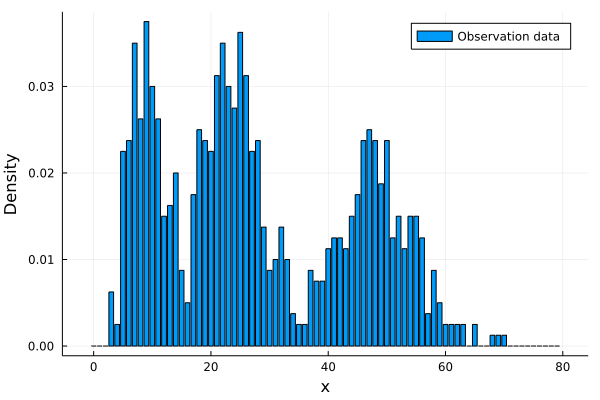

In [15]:
# 観測データ数を設定
N = 800

# 潜在変数を生成
mul = Multinomial(1, 𝛑)
𝐒 = rand(mul, N)

# クラスタ番号を抽出
𝐬 = mapslices(argmax, 𝐒, dims=1)

# 各データのクラスタに従い観測データを生成
𝛌 = [10.0, 25.0, 50.0]
poi = Poisson.(𝛌[𝐬])
𝐗 = rand.(poi)

# 確率計算、作図
x_prob = zeros(length(xs))
for x in 1:length(xs)
    x_prob[x] = count(𝐗 .== x) / length(𝐗)
end

bar(xs, x_prob, label="Observation data")
plot!(xlabel="x", ylabel="Density")

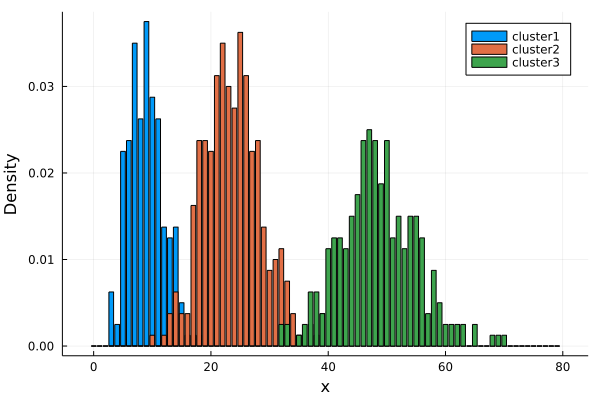

In [16]:
# クラスターごとに確率を計算
cluster1_x_prob = zeros(length(xs))
cluster2_x_prob = zeros(length(xs))
cluster3_x_prob = zeros(length(xs))

for x in 1:length(xs)
    cluster1_x_prob[x] = count(𝐗[𝐬 .== 1] .== x) / length(𝐗)
end

for x in 1:length(xs)
    cluster2_x_prob[x] = count(𝐗[𝐬 .== 2] .== x) / length(𝐗)
end

for x in 1:length(xs)
    cluster3_x_prob[x] = count(𝐗[𝐬 .== 3] .== x) / length(𝐗)
end

bar(xs, cluster1_x_prob, label="cluster1")
bar!(xs, cluster2_x_prob, label="cluster2")
bar!(xs, cluster3_x_prob, label="cluster3")
plot!(xlabel="x", ylabel="Density")

### 事前分布の設定

ポアソン分布のパラメータ $\lambda$ の事前分布としてガンマ分布（共役事前分布）を、各クラスタの混合比率 $\pi$ の事前分布としてディリクレ分布（共役事前分布）を設定する。

$$\mathcal{p}(\lambda_k) = Gam(\lambda_k|a, b)$$

$$\mathcal{p}(\boldsymbol\pi) = Dir(\boldsymbol\pi|\boldsymbol\alpha)$$

$$\quad \boldsymbol\alpha = (\alpha_1, \alpha_2,..., \alpha_K)$$


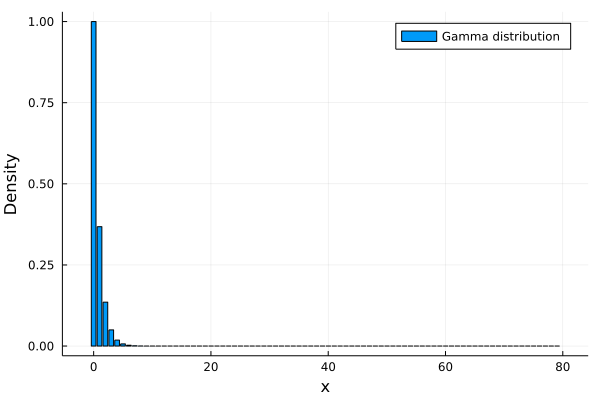

In [17]:
# ガンマ分布のパタメータを設定
a = 1.0
b = 1.0

# ガンマ分布
gam = Gamma(a, b)

# 確立密度計算、作図
λ = range(0, step=1, length=80)
bar(xs, pdf(gam, λ), label="Gamma distribution")
plot!(xlabel="x", ylabel="Density")

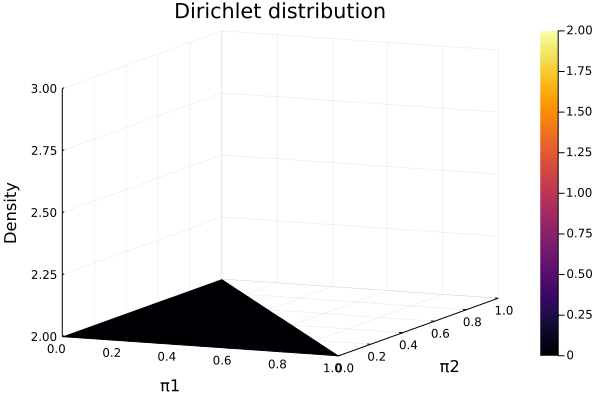

In [18]:
# ディリクレ分布のパタメータ
𝛂 = [1.0, 1.0, 1.0]

# ディリクレ分布
dir = Dirichlet(𝛂)

# 確率密度
π1_array = range(0, 1, length=100)
π2_array = range(0, 1, length=100)
dir_prob = zeros(100, 100)
for (i, π1) in enumerate(π1_array)
    for (j, π2) in enumerate(π2_array)
        π3 = 1 - (π1 + π2)
        if π3 >= 0
            dir_prob[i, j] = pdf(dir, [π1, π2, π3])
        end
    end
end

# 作図
dir_prob[dir_prob .== 0] .= NaN
surface(π1_array, π2_array, dir_prob)
plot!(xlabel="π1", ylabel="π2", zlabel="Density", title="Dirichlet distribution")